## note: As of Jan 21, 2020 This tutorial is using the GOSTnets version from this repo's master branch. Make sure that the GOSTnets version from PyPi is uninstalled and that you are pointing your path to the correct location of the library.

# Step 1: Extract from OSM
The purpose of this script is to show how to go from a .osm.pbf file to a network format that GOSTnets will accept. 
Additional modifications in this script include: clipping the roads to an input polygon (here, rek2.shp), and filtering the roads DataFrame by a list of accepted road types, as tagged in OSM (see accepted_road_types list). 

In [1]:
import geopandas as gpd
import os
import sys

In [2]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

Add to your system path the location of the LoadOSM.py and GOSTnet.py scripts.  
In this case, we use relative paths ("..") to locate the parent directory (one level up). One dot (".") means current directory.

In [3]:
sys.path.append("../")
import GOSTnets as gn

The load_osm module is an optional GOSTNets submodule that is used to import OSM data. Make sure gdal, geopy, and boltons are installed first as it has additional dependencies (look in GOSTnets repo main README file if you need additional help with this). Then import the submodule.

In [4]:
from GOSTnets.load_osm import *

Define filepaths.

In [5]:
pth = "./"  # change this path to your working folder
fil = r"iceland-latest.osm.pbf"  # download this file from geofabrik: http://download.geofabrik.de/europe/iceland.html.

# be sure to place the .osm.pbf file in the 'tutorial data' folder.

f = os.path.join(pth, "tutorial_data", fil)

In [6]:
f

'./tutorial_data\\iceland-latest.osm.pbf'

GOSTNets creates a special 'OSM_to_network' object. This object gets initialized with both a copy of the OSM file itself and the roads extracted from the OSM file in a GeoPandas DataFrame. This DataFrame is a property of the object called 'roads_raw' and is the starting point for our network.

In [7]:
iceland = OSM_to_network(f)

C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [8]:
?iceland

In [9]:
iceland.roads_raw.head()

osm_id    infra_type                                           geometry
0  2818432          path  LINESTRING (-16.87492 65.61337, -16.87472 65.6...
1  2818434          path  LINESTRING (-16.87107 65.59977, -16.86998 65.5...
2  2818477  unclassified  LINESTRING (-16.91740 65.61072, -16.91708 65.6...
3  2837331          path  LINESTRING (-16.51340 66.00186, -16.51331 66.0...
4  2837332       service  LINESTRING (-16.51283 66.00156, -16.51272 66.0...

In [10]:
# show the different highway types and counts
iceland.roads_raw.infra_type.value_counts()

service           25165
footway           15868
track              9953
residential        9519
path               7292
tertiary           4573
unclassified       2997
secondary          2898
primary            2353
trunk              1461
steps               793
trunk_link          283
platform            269
bridleway           247
primary_link        170
cycleway            124
secondary_link       95
living_street        89
tertiary_link        47
motorway             40
motorway_link        36
construction         34
pedestrian           24
proposed             16
road                 14
raceway              12
corridor              8
bus_stop              7
rest_area             2
planned               2
emergency_bay         1
abandoned             1
services              1
Name: infra_type, dtype: int64

We define a list of the types of roads from the above that we consider acceptable for our road network

In [11]:
accepted_road_types = [
    "residential",
    "unclassified",
    "track",
    "service",
    "tertiary",
    "road",
    "secondary",
    "primary",
    "trunk",
    "primary_link",
    "trunk_link",
    "tertiary_link",
    "secondary_link",
]

We call the filterRoads method and pass it a list of acceptable road types

In [12]:
iceland.filterRoads(acceptedRoads=accepted_road_types)

In [13]:
iceland.roads_raw.infra_type.value_counts()

service           25165
track              9953
residential        9519
tertiary           4573
unclassified       2997
secondary          2898
primary            2353
trunk              1461
trunk_link          283
primary_link        170
secondary_link       95
tertiary_link        47
road                 14
Name: infra_type, dtype: int64

Here, we import a shapefile for our area of interest. We want to make a map of Reykjavik, Iceland. We clip the extent of the country file to just the area around the capital (rek2.shp) below using standard GeoPandas functions:

In [14]:
clip_shp = gpd.read_file(os.path.join(pth, "tutorial_data", "rek2.shp"))
clip_shp = clip_shp.to_crs({"init": "epsg:4326"})
clip_shp_obj = clip_shp.geometry.iloc[0]

C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


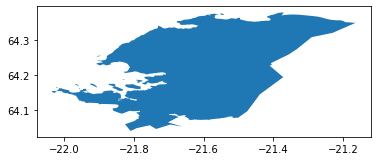

In [15]:
# this is a geopandas dataframe
clip_shp.plot()

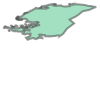

In [16]:
# this is the geometry object (shapely) from clip_shp
clip_shp_obj

We check to see everything lines up by running intersect and counting the True / False returns. The count of the True values are the number of roads that intersect the AOI

In [17]:
# intersects is a Shapely function that returns True if the boundary or interior of the object intersect in any way with those of the other
iceland.roads_raw.geometry.intersects(clip_shp_obj).value_counts()

False    48689
True     10839
dtype: int64

Remove any roads that don't intersect the capital area, by modifying the roads_raw from the 'OSM_to_network' object 

In [18]:
iceland.roads_raw = iceland.roads_raw.loc[
    iceland.roads_raw.geometry.intersects(clip_shp_obj) == True
]

Having narrowed the DataFrame to the roads we are interested in, we generate the RoadsGPD object, which is stored as a property of the 'OSM_to_network' object. The RoadsGPD object is a GeoDataFrame that further processes the roads. This includes splitting the edges where intersections occur, adding unique edge IDs, and adding to/from columns to the GeoDataFrame.

In [19]:
iceland.generateRoadsGDF(verbose=False)

C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


With the initialReadIn() function, we transform this to a graph object

In [20]:
iceland.initialReadIn()

We save this graph object down to file using gn.save(). The save function produces three outputs: a node GeoDataFrame as a CSV, an edge GeoDataFrame as a CSV, and a graph object saved as a pickle.

In [21]:
gn.save?

In [22]:
gn.save(iceland.network, "iceland_unclean", os.path.join(pth, "tutorial_outputs"))

C:\WBG\Anaconda\envs\network-analysis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Move on to Step 2 to see how we clean up this rough network.